In [160]:
import pandas as pd

from urllib.request import urlopen
from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt
import re

%matplotlib inline

In [189]:
sns.set(
    font_scale=2,
    style='whitegrid',
    rc={'figure.figsize': (20, 7)}
)

In [144]:
# функция парсинга тегов
def get_tags(link):
    tags_page = []
    try:
        html = urlopen(link).read().decode('utf-8')
        soup = BeautifulSoup(html,'html.parser')
        tags = soup.find_all(rel="tag")
        for tag in tags:
            tags_page.append(tag.text)
    except:
        return None
    if len(tags_page) == 0:
        return None
    return tags_page

In [191]:
filtered_df = pd.read_csv('1_filtered_df.csv')

In [192]:
filtered_df.head()

,id,time,likes,comments,reposts,views,text,ctr,url,year,month,day,tags
0,320900,1605604268,57,3,3,7159,Мужчина ухаживает за животными уже 25 лет. Де...,0.80,https://knife.media/raccoon-whisperer/,2020,2020-11,2020-11-17,"['животные', 'видео', 'люди', 'находка']"
1,320899,1605604203,33,1,5,7926,"Знаете, как добывали подноготную правду, зачем...",0.42,https://knife.media/origin-of-idioms/,2020,2020-11,2020-11-17,"['языки', 'история', 'насилие', 'россия']"
2,320894,1605600004,22,0,2,7755,"От проектов, помогающих детям-сиротам, до IT-с...",0.28,https://knife.media/edu-projects/,2020,2020-11,2020-11-17,"['партнерский материал', 'образование', 'будущ..."
3,320828,1605546303,106,0,13,14448,"Сказки братьев Гримм знают и любят и все, хотя...",0.73,https://knife.media/bratya-grimm/,2020,2020-11,2020-11-16,"['книги', 'литература', 'люди', 'россия']"
4,320815,1605544203,182,30,22,28388,"Раса, пол и гендер для дзен-буддистов — пустот...",0.64,https://knife.media/queer-zen/,2020,2020-11,2020-11-16,"['ЛГБТ', 'религия']"


In [193]:
from ast import literal_eval
filtered_df.tags = filtered_df.tags.apply(literal_eval)

In [194]:
explode_tags = filtered_df.explode('tags')

In [195]:
explode_tags.head()

,id,time,likes,comments,reposts,views,text,ctr,url,year,month,day,tags
0,320900,1605604268,57,3,3,7159,Мужчина ухаживает за животными уже 25 лет. Де...,0.80,https://knife.media/raccoon-whisperer/,2020,2020-11,2020-11-17,животные
0,320900,1605604268,57,3,3,7159,Мужчина ухаживает за животными уже 25 лет. Де...,0.80,https://knife.media/raccoon-whisperer/,2020,2020-11,2020-11-17,видео
0,320900,1605604268,57,3,3,7159,Мужчина ухаживает за животными уже 25 лет. Де...,0.80,https://knife.media/raccoon-whisperer/,2020,2020-11,2020-11-17,люди
0,320900,1605604268,57,3,3,7159,Мужчина ухаживает за животными уже 25 лет. Де...,0.80,https://knife.media/raccoon-whisperer/,2020,2020-11,2020-11-17,находка
1,320899,1605604203,33,1,5,7926,"Знаете, как добывали подноготную правду, зачем...",0.42,https://knife.media/origin-of-idioms/,2020,2020-11,2020-11-17,языки


In [196]:
explode_tags.shape

(23585, 13)

In [198]:
print(f'Количество уникальных тегов: {explode_tags.tags.nunique()}')

Количество уникальных тегов: 129


In [199]:
# количество уникальных тего по годам
explode_tags.groupby('year') \
    .agg({'tags': 'nunique'})

,tags
year,
2018,126
2019,125
2020,126


In [26]:
# из этого можно заключить, что названия тегов каждый год почти одни и те же

In [40]:
# посчитаем количество встречаемости тегов в статьях, найдём наиболее упоминаемые теги
count_tags = explode_tags.tags.value_counts()
count_tags = count_tags.reset_index().rename(columns={'index': 'tags', 'tags': 'counts'})

In [54]:
count_tags.head()

,tags,counts
0,россия,2214
1,общество,958
2,наука,890
3,психология,869
4,мир,809


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

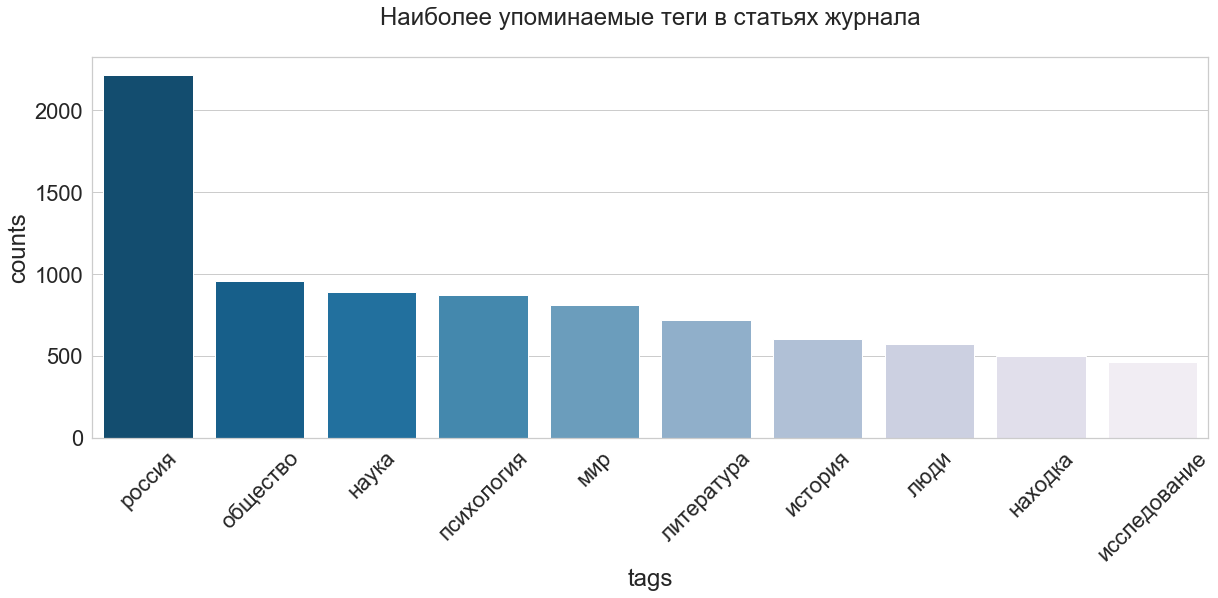

In [201]:
ax = sns.barplot(x=count_tags.head(10).tags, y=count_tags.head(10).counts, palette='PuBu_r')
ax.set_title('Наиболее упоминаемые теги в статьях журнала\n')
plt.xticks(rotation=45)

In [202]:
# далее оценим худшие и лучшие теги по их медианному значению ctr

In [203]:
# задаём порог q, по которому можно отобрать теги, которые встречаются достаточно часто,
# чтобы исключить те случаи, когда медианное значение ctr редких статей будет более высокий
# из-за этого можно сделать ошибочные выводы о качестве контента для конкретных тегов
perc = 0.25
q = count_tags.counts.quantile(perc)
print(f'Отберем теги, которые упоминались хотя бы в {int(q)} статьях. Это около {int((1-perc)*100)}% тегов от их общего числа.')

Отберем теги, которые упоминались хотя бы в 46 статьях. Это около 75% тегов от их общего числа.


In [204]:
df_tags_ctr = explode_tags.merge(count_tags, on='tags').query("counts >= @q")[['tags', 'ctr']]

In [205]:
# посчитано медианное значение ctr для отобранных тегов
tags_median_ctr = df_tags_ctr.groupby('tags', as_index=False) \
    .agg({'ctr': 'median'}) \
    .sort_values('ctr', ascending=False) \
    .rename(columns={'ctr': 'median_ctr'})

In [206]:
# лучшие и худшие теги по медианному значению ctr
best_tags_median_ctr = tags_median_ctr.head(10)
bad_tags_median_ctr = tags_median_ctr.tail(10)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

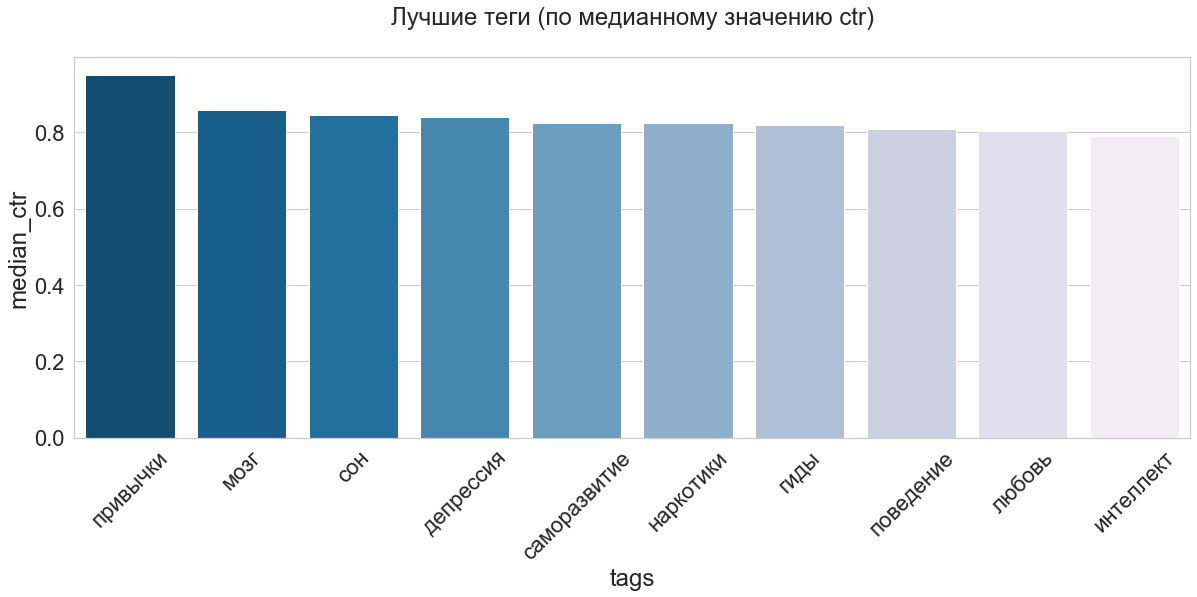

In [207]:
ax = sns.barplot(x=best_tags_median_ctr.tags, y=best_tags_median_ctr.median_ctr, palette='PuBu_r')
ax.set_title('Лучшие теги (по медианному значению ctr)\n')
plt.xticks(rotation=45) 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

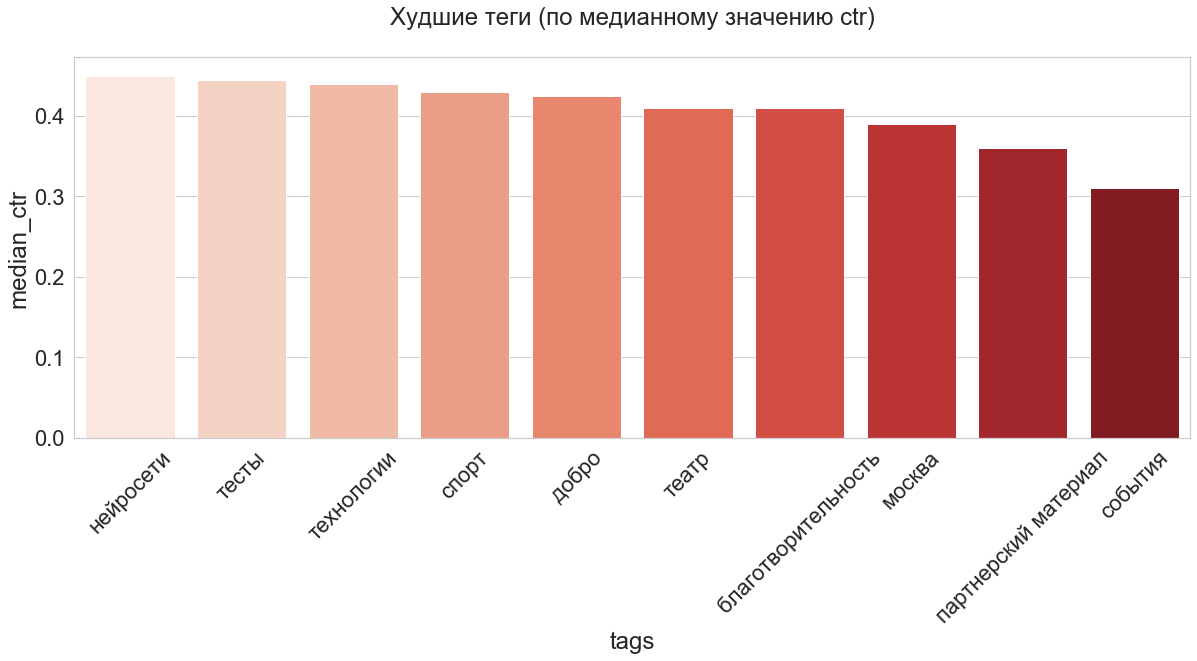

In [208]:
ax = sns.barplot(x=bad_tags_median_ctr.tags, y=bad_tags_median_ctr.median_ctr, palette='Reds')
ax.set_title('Худшие теги (по медианному значению ctr)\n')
plt.xticks(rotation=45) 

### Сравнение характерных тегов лучших и худших статей

In [80]:
# наиболее упоминаемые теги, отобранные выше, могут встречаться как среди качественного контента, так и наоборот

In [209]:
q = filtered_df.views.quantile(0.25)
print(f'quant_views = {q}')
# отбор более представительных статей
filtered_df = filtered_df.query("views >= @q")

quant_views = 19800.25


In [210]:
# отберём по 100 статей лучших и худших по ctr
best_posts_ctr = filtered_df.sort_values('ctr', ascending=False).head(100)
bad_posts_ctr = filtered_df.sort_values('ctr', ascending=False).tail(100)

In [211]:
best_posts_ctr = best_posts_ctr.explode('tags')
bad_posts_ctr = bad_posts_ctr.explode('tags')

### Анализ тегов лучших статей

In [212]:
best_posts_ctr.head()

,id,time,likes,comments,reposts,views,text,ctr,url,year,month,day,tags
597,309190,1599815710,719,61,24,35340,Пятничное благословение.\n\nhttps://knife.medi...,2.03,https://knife.media/food-and-sex/,2020,2020-09,2020-09-11,религия
597,309190,1599815710,719,61,24,35340,Пятничное благословение.\n\nhttps://knife.medi...,2.03,https://knife.media/food-and-sex/,2020,2020-09,2020-09-11,еда
597,309190,1599815710,719,61,24,35340,Пятничное благословение.\n\nhttps://knife.medi...,2.03,https://knife.media/food-and-sex/,2020,2020-09,2020-09-11,секс
1085,298049,1595062982,632,28,8,30781,"Суд Саудовской Аравии постановил, что женщина ...",2.05,https://knife.media/saudi-historic-verdict/,2020,2020-07,2020-07-18,мир
1085,298049,1595062982,632,28,8,30781,"Суд Саудовской Аравии постановил, что женщина ...",2.05,https://knife.media/saudi-historic-verdict/,2020,2020-07,2020-07-18,женщины


In [213]:
print('Общее количество тегов в лучших статьях = {}'.format(best_posts_ctr.tags.count()))

Общее количество тегов в лучших статьях = 302


In [214]:
print(f'Количество уникальных тегов в лучших статьях = {best_posts_ctr.tags.nunique()}')

Количество уникальных тегов в лучших статьях = 69


In [215]:
best_tags = best_posts_ctr.tags.value_counts()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

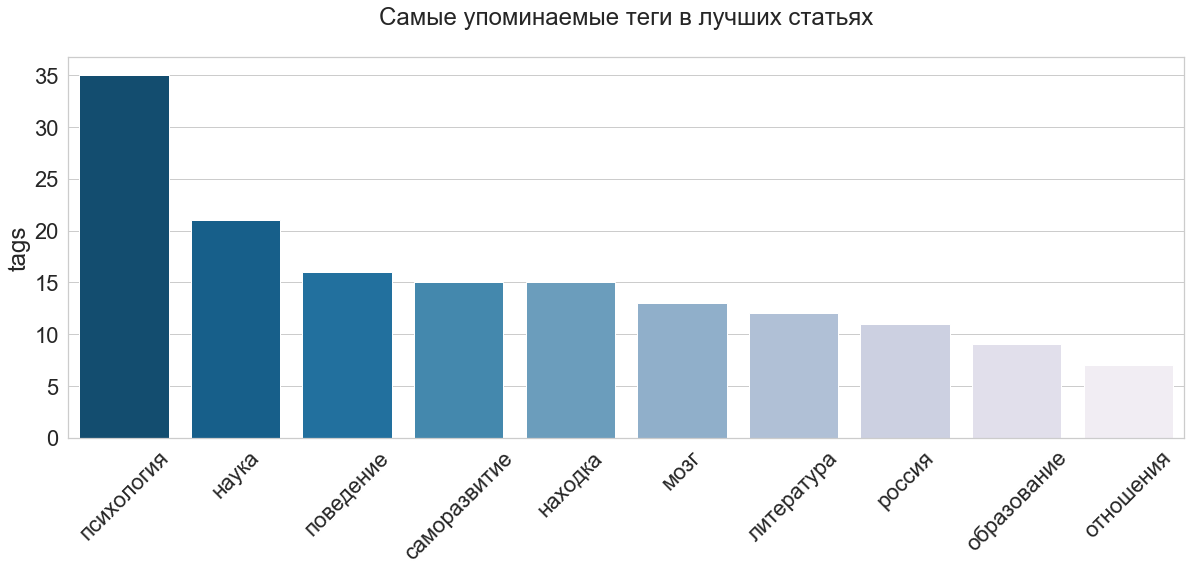

In [216]:
top_best_tags = best_tags.head(10)
ax = sns.barplot(x=top_best_tags.index, y=top_best_tags, palette='PuBu_r')
ax.set_title('Самые упоминаемые теги в лучших статьях\n')
plt.xticks(rotation=45) 

### Анализ тегов худших статей

In [217]:
bad_posts_ctr.head()

,id,time,likes,comments,reposts,views,text,ctr,url,year,month,day,tags
81,319419,1604675403,48,15,4,34995,Евгений «Маэстро» Дмитерко — артист милостью б...,0.14,https://knife.media/maestro-ryba/,2020,2020-11,2020-11-06,интервью
81,319419,1604675403,48,15,4,34995,Евгений «Маэстро» Дмитерко — артист милостью б...,0.14,https://knife.media/maestro-ryba/,2020,2020-11,2020-11-06,видео
81,319419,1604675403,48,15,4,34995,Евгений «Маэстро» Дмитерко — артист милостью б...,0.14,https://knife.media/maestro-ryba/,2020,2020-11,2020-11-06,россия
199,316931,1603455004,31,1,2,23268,Призерам чемпионата ArtMasters вручили денежны...,0.13,https://knife.media/artmasters-rep/,2020,2020-10,2020-10-23,партнерский материал
199,316931,1603455004,31,1,2,23268,Призерам чемпионата ArtMasters вручили денежны...,0.13,https://knife.media/artmasters-rep/,2020,2020-10,2020-10-23,события


In [218]:
print('Общее количество тегов в худших статьях = {}'.format(bad_posts_ctr.tags.count()))

Общее количество тегов в худших статьях = 325


In [219]:
print(f'Количество различных тегов в худших статьях = {bad_posts_ctr.tags.nunique()}')

Количество различных тегов в худших статьях = 81


In [220]:
bad_tags = bad_posts_ctr.tags.value_counts()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

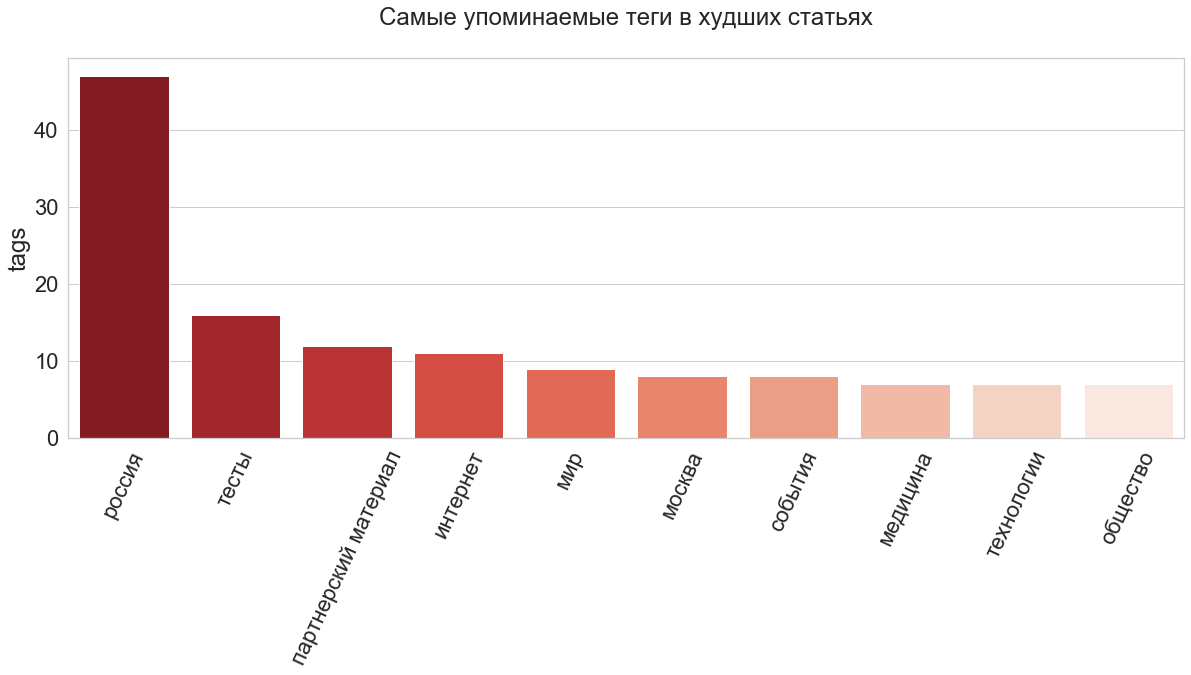

In [221]:
top_bad_tags = bad_tags.head(10)
ax = sns.barplot(x=top_bad_tags.index, y=top_bad_tags, palette='Reds_r')
ax.set_title('Самые упоминаемые теги в худших статьях\n')
plt.xticks(rotation=65) 

In [222]:
top_best_tags

психология      35
наука           21
поведение       16
саморазвитие    15
находка         15
мозг            13
литература      12
россия          11
образование      9
отношения        7
Name: tags, dtype: int64

In [223]:
top_bad_tags

россия                  47
тесты                   16
партнерский материал    12
интернет                11
мир                      9
москва                   8
события                  8
медицина                 7
технологии               7
общество                 7
Name: tags, dtype: int64

In [224]:
print('Общие темы лучших и худших статей:', end=' ')
print(*top_best_tags.loc[top_best_tags.index.isin(top_bad_tags.index)].index, sep=', ', end='.')

Общие темы лучших и худших статей: россия.

### Сравненительный анализ совпадающих характерных тегов лучших и худших статей

In [225]:
# тег "россия", является самым распространённым тегом статей журнала, неудивительно, 
# что он попал и топ лучших и в топ худших статей
# однако проверим, какие ещё теги присутсвовали в тех статьях из списка лучших, в которых присутствовал тег "россия"
# то же самое выясним для худших статей, посмотрим, совпадают ли такие теги в лучших и худших статьях

### Тег: россия

In [226]:
best_common_topic_russia = best_posts_ctr.query("tags == 'россия'")

In [227]:
best_common_topic_russia['tags'] = best_common_topic_russia.url.apply(get_tags)

C:\Users\anafem\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


###### другие теги в лучших статьях

In [228]:
best_common_topic_russia.explode('tags').query("tags != 'россия'").tags.value_counts().head()

находка        5
образование    5
литература     2
искусство      2
интернет       2
Name: tags, dtype: int64

In [229]:
bad_common_topic_russia = bad_posts_ctr.query("tags == 'россия'")

In [230]:
bad_common_topic_russia['tags'] = bad_common_topic_russia.url.apply(get_tags)

C:\Users\anafem\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


###### другие теги в худших статьях

In [231]:
bad_common_topic_russia.explode('tags').query("tags != 'россия'").tags.value_counts().head()

москва                  7
события                 6
партнерский материал    6
тесты                   5
общество                5
Name: tags, dtype: int64

In [232]:
# таким образом смежные теги различны